 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 4: Optimisation sans contraintes et méthodes itératives
Tangi Migot et Paul Raynaud

Rédigé par Adam Osmani 2026348

In [46]:
#import Pkg
#Pkg.add("Krylov")
using LinearAlgebra, Krylov, NLPModels, Printf, Logging, SolverCore, Test, ADNLPModels

## Exercice 0: Introduction aux NLSModels

On a vu dans les lab précédents l'utilisation des NLPModels pour représenter un problème d'optimisation. Dans le cas de l'optimisation de moindre carrées non-linéaires, il existe un type spécifique: **NLSModel**.

$\min_x \frac{1}{2} \| F(x) \|^2$

Comme un NLPModel classique on peut faire appels aux fonctions: obj, grad, hprod ...

Mais on peut aussi utiliser des fonctions relatives à $F$:
https://juliasmoothoptimizers.github.io/NLPModels.jl/stable/#Nonlinear-Least-Squares

In [47]:
#? NLPModels.residual

L'équivalent des ADNLPModel pour ce cas est la fonction: ADNLSModel.
Lien vers le site: https://juliasmoothoptimizers.github.io/ADNLPModels.jl/stable/

In [48]:
#? ADNLPModels.ADNLSModel

En utilisant les ADNLSModels écrire un modèle dont la fonction résidue est donné par FH ci-dessous.

In [49]:
#Test problem:
FH(x) = [x[2]+x[1].^2-11, x[1]+x[2].^2-7]
x0H = [10., 20.]
###########################
#Utilise FH et x0H pour créer un ADNLSModel
himmelblau_nls = ADNLSModel(FH,x0H,2)
###########################

ADNLSModel - Nonlinear least-squares model with automatic differentiation backend ADNLPModels.ForwardDiffAD{ForwardDiff.GradientConfig{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}, Float64, 2}}}}(3, 0, ForwardDiff.GradientConfig{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}, Float64, 2}}}((Partials(1.0, 0.0), Partials(0.0, 1.0)), ForwardDiff.Dual{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}, Float64, 2}[Dual{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}}(1.27402949085e-311,1.273959003872e-311,1.273959004022e-311), Dual{ForwardDiff.Tag{ADNLPModels.var"#59#62"{typeof(FH)}, Float64}}(1.2739784245647e-311,1.2739784245964e-311,1.274351721895e-311)]))
  Problem name: Generic
   All variables: ████████████████████ 2      All constrai

## Exercice 1: Gauss-Newton

Dans cet exercice, on complète une implémentation de la méthode Gauss-Newton avec région de confiance (paramétrée par $\Delta$) discutée en cours.

Il faut compléter les morceaux:
- utiliser les fonctions des NLSModels pour obtenir F et sa jacobienne (ici on utilise pas la jacobienne mais juste le produit jacobienne-vecteur).
Parcourez la documentation de NLPModels pour déterminer la fonction adéquat, indice les fonctions pour les NLSModels indiquent des `nls` au lieu de `nlp` dans la documentation.
- Utiliser la fonction `lsmr` du package `Krylov.jl` pour résoudre le système linéaire avec une contrainte de `radius`. Lisez la [documentation de `lsmr`](https://jso.dev/Krylov.jl/stable/solvers/ls/#LSMR).

In [50]:
function gauss_newton(nlp      :: AbstractNLSModel, 
                      x        :: AbstractVector, 
                      ϵ        :: AbstractFloat;
                      η₁       :: AbstractFloat = 1e-3, 
                      η₂       :: AbstractFloat = 0.66, 
                      σ₁       :: AbstractFloat = 0.25, 
                      σ₂       :: AbstractFloat = 2.0,
                      max_eval :: Int = 1_000, 
                      max_time :: AbstractFloat = 60.,
                      max_iter :: Int = typemax(Int64)
                      )
    ######################################################
    Fx = residual(nlp, x)# le résidu
    Jx = jac_residual(nlp, x)# operateur qui représente le jacobien du résidu
    ######################################################
    normFx = norm(Fx)

    Δ = 1.

    iter = 0    

    el_time = 0.0
    tired   = neval_residual(nlp) > max_eval || el_time > max_time
    status  = :unknown

    start_time = time()
    too_small  = false
    normdual   = norm(Jx' * Fx)
    optimal    = min(normFx, normdual) ≤ ϵ

    @info log_header([:iter, :nf, :primal, :status, :nd, :Δ],
    [Int, Int, Float64, String, Float64, Float64],
    hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

    while !(optimal || tired || too_small)

        #################################
        #Compute a direction satisfying the trust-region constraint
        (d, stats)  = lsmr(Jx, -Fx, radius = Δ)
        #################################
      
        too_small = norm(d) < 1e-15
        if too_small #the direction is too small
            status = :too_small
        else
            xp      = x + d
            ###########################
            Fxp     = residual(nlp, xp) # évalue le résidu en xp
            ###########################
            normFxp = norm(Fxp)

            Pred = 0.5 * (normFx^2 - norm(Jx * d + Fx)^2)
            Ared = 0.5 * (normFx^2 - normFxp^2)

            if Ared/Pred < η₁
                Δ = max(1e-8, Δ * σ₁)
                status = :reduce_Δ
            else #success
                x  = xp
                ###########################
                Jx = jac_residual(nlp, x)# réevalue le jacobien en x
                ###########################
                Fx = Fxp
                normFx = normFxp
                status = :success
                if Ared/Pred > η₂ && norm(d) >= 0.99 * Δ
                    Δ *= σ₂
                end
            end
        end

        @info log_row(Any[iter, neval_residual(nlp), normFx, status, norm(d), Δ])

        el_time      = time() - start_time
        iter   += 1

        many_evals   = neval_residual(nlp) > max_eval
        iter_limit   = iter > max_iter
        tired        = many_evals || el_time > max_time || iter_limit
        normdual     = norm(Jx' * Fx)
        optimal      = min(normFx, normdual) ≤ ϵ
    end

    status = if optimal 
        :first_order
    elseif tired
        if neval_residual(nlp) > max_eval
            :max_eval
        elseif el_time > max_time
            :max_time
        elseif iter > max_iter
            :max_iter
        else
            :unknown_tired
        end
    elseif too_small
        :stalled
    else
        :unknown
    end

    return GenericExecutionStats(nlp; status, solution = x,
                                 objective = normFx^2 / 2,
                                 dual_feas = normdual,
                                 iter = iter, 
                                 elapsed_time = el_time)
end

gauss_newton (generic function with 1 method)

In [51]:
stats = gauss_newton(himmelblau_nls, himmelblau_nls.meta.x0, 1e-6)
@test stats.status == :first_order
include("test1.jl")

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:31
┌ Info:      0       2   3.8e+02          success   1.0e+00   2.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      1       3   3.1e+02          success   2.0e+00   4.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      2       4   1.9e+02          success   4.0e+00   8.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      3       5   4.5e+01          success   7.7e+00   8.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      4       6   9.5e+00          success   3.4e+00   8.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-

  0.270666 seconds (805.59 k allocations: 55.594 MiB, 99.40% compilation time)


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:31
┌ Info:      0       2   4.9e+01          success   1.0e+00   2.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      1       3   1.2e+01          success   2.0e+00   4.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      2       4   8.3e+00          success   2.5e+00   4.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      3       5   2.2e-12          success   8.3e-01   4.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72


  0.324860 seconds (818.98 k allocations: 56.484 MiB, 17.13% gc time, 99.67% compilation time)


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:31
┌ Info:      0       2   3.0e+00          success   1.0e+00   2.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      1       3   1.0e+00          success   2.0e+00   4.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      2       4   0.0e+00          success   1.0e+00   4.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72


  0.279884 seconds (823.31 k allocations: 57.104 MiB, 98.95% compilation time)


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:31
┌ Info:      0       2   7.6e+00          success   1.0e+00   2.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      1       3   9.6e-01          success   1.1e+00   2.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      2       4   4.6e-02          success   2.1e-01   2.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      3       5   1.4e-04          success   1.2e-02   2.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      4       6   1.4e-09          success   3.8e-05   2.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-

  0.432691 seconds (903.36 k allocations: 62.217 MiB, 99.66% compilation time)
Test Summary:             | Pass  Total  Time
Test set for Gauss-Newton |    4      4  1.6s


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:31
┌ Info:      0       2   2.9e+02          success   1.0e+00   2.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      1       3   1.8e+02          success   2.0e+00   4.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      2       4   4.2e+01          success   4.0e+00   8.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      3       5   1.3e+01          success   3.1e+00   8.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      4       6   1.1e+00          success   1.2e+00   8.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-

Test.DefaultTestSet("Test set for Gauss-Newton", Any[], 4, false, false, true, 1.709500006756e9, 1.709500008384e9, false, "c:\\Users\\adamo\\OneDrive\\Documents\\POLY\\H24\\MTH8408\\MTH8408-Hiv24\\lab4\\test1.jl")

## Exercice 2: Méthode Levenberg-Marquard inexacte

Dans cet exercice, on complète une implémentation de la méthode Levenberg-Marquardt. Pour compléter le code `lm_param` on va utiliser les fonctions suivantes:
- `dsol` qui calcul la solution du système 
$\min_x \frac{1}{2}\|J(x) d + F(x)\| + \lambda \|x\|^2$
avec la fonction `lsqr` du package `Krylov.jl`.
- `multi_sol` qui pour un entier nl donné et un $\mu$ va résoudre le problème de dsol pour nl valeurs de $\lambda$ (autour de la valeur $\mu$). Par exemple, pour $\mu=10^{-6}$ et $nl=3$, on prendra $\lambda=10^{-7}, 10^{-6},10^{-5}$.
Parmis les `nl` directions calculées, on retourne celle qui donne la plus petite valeur de $\|F(x+d)\|^2$.

In [52]:
function dsol(Fx, Jx, λ, τ)
    # TODO.

    (d, stats) = lsmr(Jx, -Fx, λ = λ, timemax = τ)

    return d
end

dsol (generic function with 1 method)

In [53]:
function multi_sol(nlp, x, Fx, Jx, λ, τ; nl = 3)
    # TODO
    μ = λ
    N = Any[]
    dk = Any[]
    for i = 1:nl
        λ = μ*exp10(floor(-nl/2)+i)
        push!(dk,dsol(Fx, Jx, λ, τ))
        push!(N,residual(nlp, x + dk[i]))
    end
    d = dk[argmin(norm(N))]
    return d
end

multi_sol (generic function with 1 method)

In [54]:
function lm_param(nlp      :: AbstractNLSModel, 
                  x        :: AbstractVector, 
                  ϵ        :: AbstractFloat;
                  η₁       :: AbstractFloat = 1e-3, 
                  η₂       :: AbstractFloat = 0.66, 
                  σ₁       :: AbstractFloat = 10.0, 
                  σ₂       :: AbstractFloat = 0.5,
                  max_eval :: Int = 10_000, 
                  max_time :: AbstractFloat = 60.,
                  max_iter :: Int = typemax(Int64)
                  )
    ######################################################
    Fx = residual(nlp, x)# le résidu
    Jx = jac_residual(nlp, x)# operateur qui représente le jacobien du résidu
    ######################################################
    normFx   = norm(Fx)
    normdual = norm(Jx' * Fx)

    iter = 0    
    λ = 0.0
    λ₀ = 1e-6
    η = 0.5
    τ = η * normdual

    el_time = 0.0
    tired   = neval_residual(nlp) > max_eval || el_time > max_time
    status  = :unknown

    start_time = time()
    too_small  = false
    optimal    = min(normFx, normdual) ≤ ϵ

    @info log_header([:iter, :nf, :primal, :status, :nd, :λ],
    [Int, Int, Float64, String, Float64, Float64],
    hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

    while !(optimal || tired || too_small)

        ###########################
        # (d, stats)  = lsqr(Jx, -Fx, λ = λ, atol = τ)
        d = multi_sol(nlp, x, Fx, Jx, λ, τ)
        ###########################
        
        too_small = norm(d) < 1e-16
        if too_small #the direction is too small
            status = :too_small
        else
            xp      = x + d
            ###########################
            Fxp     = residual(nlp, xp)# évalue le résidu en xp
            ###########################
            normFxp = norm(Fxp)

            Pred = 0.5 * (normFx^2 - norm(Jx * d + Fx)^2 - λ*norm(d)^2)
            Ared = 0.5 * (normFx^2 - normFxp^2)

            if Ared/Pred < η₁
                λ = max(λ₀, σ₁ * λ)
                status = :increase_λ
            else #success
                x  = xp
                ###########################
                Jx = jac_residual(nlp,x)# réevalue le jacobien en x
                ###########################
                Fx = Fxp
                normFx = normFxp
                status = :success
                if Ared/Pred > η₂
                    λ = max(λ * σ₂, λ₀)
                end
            end
        end

        @info log_row(Any[iter, neval_residual(nlp), normFx, status, norm(d), λ])

        el_time      = time() - start_time
        iter        += 1
        many_evals   = neval_residual(nlp) > max_eval
        iter_limit   = iter > max_iter
        tired        = many_evals || el_time > max_time || iter_limit
        normdual     = norm(Jx' * Fx)
        optimal      = min(normFx, normdual) ≤ ϵ

        η = λ == 0.0 ? min(0.5, 1/iter, normdual) : min(0.5, 1/iter)
        τ = η * normdual
    end

    status = if optimal 
        :first_order
    elseif tired
        if neval_residual(nlp) > max_eval
            :max_eval
        elseif el_time > max_time
            :max_time
        elseif iter > max_iter
            :max_iter
        else
            :unknown_tired
        end
    elseif too_small
        :stalled
    else
        :unknown
    end

    return GenericExecutionStats(nlp; status, solution = x,
                                objective = normFx^2 / 2,
                                dual_feas = normdual,
                                iter = iter,
                                elapsed_time = el_time)

end

lm_param (generic function with 1 method)

In [55]:
stats = lm_param(himmelblau_nls, himmelblau_nls.meta.x0, 1e-6)
@test stats.status == :first_order
include("test2.jl")

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:33
┌ Info:      0      15   1.0e+02          success   1.1e+01   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      1      19   2.4e+01          success   5.2e+00   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      2      23   4.9e+00          success   2.2e+00   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      3      27   7.0e-01          success   8.5e-01   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      4      31   2.8e-02          success   1.7e-01   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-

  0.312587 seconds (805.37 k allocations: 55.588 MiB, 18.17% gc time, 99.66% compilation time)


┌ Info:      6      39   1.8e-10          success   1.3e-05   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:33
┌ Info:      0       5   9.0e+01          success   1.2e+01   0.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      1       9   1.5e-11          success   9.0e+00   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:33
┌ Info:      0       5   0.0e+00          success   4.0e+00   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74


  0.248143 seconds (818.67 k allocations: 56.453 MiB, 99.63% compilation time)


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:33
┌ Info:      0       5   2.4e+00          success   1.8e+00   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      1       9   2.0e-01          success   4.5e-01   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      2      13   2.4e-03          success   5.0e-02   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      3      17   4.0e-07          success   6.4e-04   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74


  0.265526 seconds (823.36 k allocations: 56.772 MiB, 99.13% compilation time)
  0.302985 seconds (903.42 k allocations: 62.212 MiB, 99.24% compilation time)
Test Summary:   | Pass  Total  Time
Test set for LM |    4      4  1.4s


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:33
┌ Info:      0       5   1.3e+02          success   1.5e+01   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      1       9   1.9e+01          success   1.0e+01   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      2      13   3.3e+00          success   9.8e-01   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      3      17   2.4e-01          success   2.5e-01   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      4      21   1.8e-03          success   2.1e-02   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-

Test.DefaultTestSet("Test set for LM", Any[], 4, false, false, true, 1.709500008704e9, 1.709500010133e9, false, "c:\\Users\\adamo\\OneDrive\\Documents\\POLY\\H24\\MTH8408\\MTH8408-Hiv24\\lab4\\test2.jl")

## Exercice 3: Rocket Control

Dans les cellules ci-dessous nous introduisons un modèle de contrôle optimal (cf. https://en.wikipedia.org/wiki/Optimal_control ) pour le contrôle d'une fusée dont une version discrétisée a été modélisé avec JuMP:

Le lien vers le tutoriel:
https://nbviewer.jupyter.org/github/jump-dev/JuMPTutorials.jl/blob/master/notebook/modelling/rocket_control.ipynb

In [56]:
using JuMP, Ipopt

# Create JuMP model, using Ipopt as the solver
rocket = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))

# Constants
# Note that all parameters in the model have been normalized
# to be dimensionless. See the COPS3 paper for more info.
h_0 = 1    # Initial height
v_0 = 0    # Initial velocity
m_0 = 1    # Initial mass
g_0 = 1    # Gravity at the surface

T_c = 3.5  # Used for thrust
h_c = 500  # Used for drag
v_c = 620  # Used for drag
m_c = 0.6  # Fraction of initial mass left at end

c     = 0.5 * sqrt(g_0 * h_0)  # Thrust-to-fuel mass
m_f   = m_c * m_0            # Final mass
D_c   = 0.5 * v_c * m_0 / g_0    # Drag scaling
T_max = T_c * g_0 * m_0        # Maximum thrust

n = 800   # Time steps

@variables(rocket, begin
    Δt ≥ 0, (start = 1/n) # Time step
    # State variables
    v[1:n] ≥ 0            # Velocity
    h[1:n] ≥ h_0          # Height
    m_f ≤ m[1:n] ≤ m_0    # Mass
    # Control
    0 ≤ T[1:n] ≤ T_max    # Thrust
end)

# Objective: maximize altitude at end of time of flight
@objective(rocket, Max, h[n])

# Initial conditions
@constraints(rocket, begin
    v[1] == v_0
    h[1] == h_0
    m[1] == m_0
    m[n] == m_f
end)

# Forces
# Drag(h,v) = Dc v^2 exp( -hc * (h - h0) / h0 )
@NLexpression(rocket, drag[j = 1:n], D_c * (v[j]^2) * exp(-h_c * (h[j] - h_0) / h_0))
# Grav(h)   = go * (h0 / h)^2
@NLexpression(rocket, grav[j = 1:n], g_0 * (h_0 / h[j])^2)
# Time of flight
@NLexpression(rocket, t_f, Δt * n)

# Dynamics
for j in 2:n
    # h' = v
    
    # Rectangular integration
    # @NLconstraint(rocket, h[j] == h[j - 1] + Δt * v[j - 1])
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        h[j] == h[j - 1] + 0.5 * Δt * (v[j] + v[j - 1]))

    # v' = (T-D(h,v))/m - g(h)
    
    # Rectangular integration
    # @NLconstraint(rocket, v[j] == v[j - 1] + Δt *(
    #                 (T[j - 1] - drag[j - 1]) / m[j - 1] - grav[j - 1]))
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        v[j] == v[j-1] + 0.5 * Δt * (
            (T[j] - drag[j] - m[j] * grav[j]) / m[j] +
            (T[j - 1] - drag[j - 1] - m[j - 1] * grav[j - 1]) / m[j - 1]))

    # m' = -T/c

    # Rectangular integration
    # @NLconstraint(rocket, m[j] == m[j - 1] - Δt * T[j - 1] / c)
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        m[j] == m[j - 1] - 0.5 * Δt * (T[j] + T[j-1]) / c)
end

In [57]:
# Solve for the control and state
println("Solving...")
status = optimize!(rocket)

# Display results
# println("Solver status: ", status)
println("Max height: ", objective_value(rocket))

Solving...


Max height: 1.0128340648308067


In [58]:
value.(h)[n]

1.0128340648308067

In [59]:
# Can visualize the state and control variables
import Pkg
Pkg.add("Gadfly")
using Gadfly

   Resolving package versions...


  No Changes to `C:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\Project.toml`
  No Changes to `C:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\Manifest.toml`

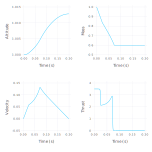

In [60]:
h_plot = plot(x = (1:n) * value.(Δt), y = value.(h)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = plot(x = (1:n) * value.(Δt), y = value.(m)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = plot(x = (1:n) * value.(Δt), y = value.(v)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = plot(x = (1:n) * value.(Δt), y = value.(T)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot, m_plot), hstack(v_plot, T_plot)))

### Questions:     
    - i) Transformer le modèle JuMP utilisé ci-dessus en un NLPModel en utilisant le package `NLPModelsJuMP`.    
    - ii) Résoudre ce nouveau modèle avec `Ipopt` en utilisant `NLPModelsIpopt`.    
    - iii) Calcul séparément la différence entre les h,v,m,T, Δt calculés.    
    - iv) Est-ce que le contrôle T atteint ses bornes ?    
    - v) Reproduire les graphiques ci-dessous avec la solution calculée via `NLPModelsIpopt`.


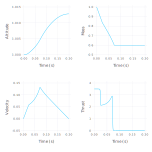

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    15185
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45543

Total number of variables............................:     3201
                     variables with only lower bounds:     1601
                variables with lower and upper bounds:     1600
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2401
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.96e-01 2.13e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [61]:
#import Pkg
#Pkg.add("NLPModelsJuMP")
#Pkg.add("NLPModelsIpopt")
using NLPModels, LinearAlgebra, NLPModelsJuMP, NLPModelsIpopt

nlp = NLPModelsJuMP.MathOptNLPModel(rocket)
stats = ipopt(nlp)
vecteur_solution = stats.solution
Δt2 = vecteur_solution[1]
v2 = vecteur_solution[2:n+1]
h2 = vecteur_solution[n+2:2*n+1]
m2 = vecteur_solution[2*n+2:3*n+1]
T2 = vecteur_solution[3*n+2:4*n+1]

println("T2 valeur initiale:",T2[1])
println("T2 valeur finale:",T2[800])
println("On voit que les conditions aux bornes sont respectées pour T")

h_plot = plot(x = (1:n) * value.(Δt2), y = value.(h2)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = plot(x = (1:n) * value.(Δt2), y = value.(m2)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = plot(x = (1:n) * value.(Δt2), y = value.(v2)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = plot(x = (1:n) * value.(Δt2), y = value.(T2)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot, m_plot), hstack(v_plot, T_plot)))

In [62]:
## Exercice 1
#
#import Pkg
#Pkg.add("NLSProblems")
#Pkg.add("SolverBenchmark")
#Pkg.add("Plots")
using NLPModels, NLPModelsJuMP, NLSProblems, SolverBenchmark, Plots

nls_mgh30 = mgh30()

stats = gauss_newton(nls_mgh30, nls_mgh30.meta.x0, 1e-6)
@test stats.status == :first_order


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:31
┌ Info:      0       2   6.6e-01          success   9.6e-01   1.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      1       3   3.0e-02          success   1.9e-01   1.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      2       4   9.2e-05          success   9.8e-03   1.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72
┌ Info:      3       5   1.1e-09          success   3.1e-05   1.0e+00
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:72


Test Passed

In [63]:
## Exercice 2
#

stats = lm_param(nls_mgh30, nls_mgh30.meta.x0, 1e-6)
@test stats.status == :first_order

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         λ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:33
┌ Info:      0      10   6.6e-01          success   9.6e-01   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      1      14   3.0e-02          success   1.9e-01   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      2      18   9.2e-05          success   9.8e-03   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74
┌ Info:      3      22   1.1e-09          success   3.1e-05   1.0e-06
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab4\Lab4-notebook.ipynb:74


Test Passed

In [64]:
## Exercice 3
#
#Pkg.add("CaNNOLeS")
#Pkg.add("JSOSolvers")
using CaNNOLeS, JSOSolvers, NLPModels, NLPModelsJuMP, NLSProblems, SolverBenchmark

problems = (eval(problem)() for problem ∈ filter(x -> x != :NLSProblems, names(NLSProblems)))

solvers = Dict(
  :gauss => model -> gauss_newton(model,model.meta.x0,1e-6),
  :lm => model -> lm_param(model,model.meta.x0,1e-6),
)

stats = bmark_solvers(
  solvers, problems,
  skipif=prob -> (!unconstrained(prob) || get_nvar(prob) > 100 || get_nvar(prob) < 5),
)


┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:127
┌ Info:            NZF1      13       0      first_order   0.0e+00   3.4e-20   1.0e-09   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           mgh17       5       0      first_order   1.0e-03   2.7e-05   1.5e-08   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           mgh18       6       0          stalled   0.0e+00   4.7e+00   1.5e-02   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           mgh19      11       0          stalled   4.0e-03   9.3e+14   5.8e+41   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           mgh20       6       

┌ Info:           mgh34      10       0      first_order   0.0e+00   3.1e+00   4.2e-10   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp266       5       0      first_order   3.1e-02   5.0e-01   9.6e-07   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175


┌ Info:           tp267       5       0         max_eval   5.1e-01       NaN       NaN   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp271       6       0      first_order   0.0e+00   4.1e-29   1.1e-13   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp272       6       0          stalled   0.0e+00   4.7e+00   1.5e-01   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp273       6       0      first_order   0.0e+00   2.1e-17   7.3e-08   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp282      10       0         max_eval   4.7e-02   4.6e-01   2.0e-02   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp286      20       0 

┌ Info:           tp288      20       0         max_eval   4.9e-02   4.2e-09   2.5e-06   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp291      10       0      first_order   0.0e+00   5.6e-10   5.0e-07   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp292      30       0         max_eval   5.2e-02   9.4e-05   3.3e-03   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175


┌ Info:           tp293      50       0         max_eval   9.0e-02   9.5e-05   3.3e-03   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp294       6       0         max_eval   4.3e-02   2.4e-05   3.5e-03   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175


┌ Info:           tp295      10       0         max_eval   2.4e-01   5.6e-05   5.3e-03   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175


┌ Info:           tp296      16       0         max_eval   1.0e-01   1.6e-04   9.0e-03   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175


┌ Info:           tp297      30       0         max_eval   1.6e-01   7.0e-04   1.9e-02   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175


┌ Info:           tp298      50       0         max_eval   1.3e-01   3.7e-02   1.7e-01   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175


┌ Info:           tp299     100       0         max_eval   9.2e-01   2.2e+01   1.2e+00   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp303      20       0      first_order   0.0e+00   6.2e-14   9.5e-06   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp304      50       0      first_order   2.0e-03   7.6e-21   1.3e-08   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp305     100       0      first_order   1.0e-03   3.7e-21   2.5e-08   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp370       6       0      first_order   3.8e-02   1.1e-03   1.0e-06   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp371       9       0 

┌ Info:           tp379      11       0          stalled   2.0e-03   2.8e+00   5.6e+01   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:127


┌ Info:            NZF1      13       0      first_order   0.0e+00   9.2e-19   5.2e-09   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           mgh17       5       0      first_order   0.0e+00   2.7e-05   1.0e-07   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           mgh18       6       0      first_order   0.0e+00   2.8e-03   3.9e-07   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           mgh19      11       0      first_order   1.0e-03   2.0e-02   3.9e-07   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           mgh20       6       0      first_order   1.0e-03   1.1e-03   8.2e-07   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           mgh21      20       0 

┌ Info:           tp370       6       0      first_order   2.0e-03   1.1e-03   8.2e-07   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp371       9       0      first_order   0.0e+00   7.0e-07   8.1e-07   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175
┌ Info:           tp379      11       0      first_order   2.0e-03   2.0e-02   7.7e-07   0.0e+00
└ @ SolverBenchmark C:\Users\adamo\.julia\packages\SolverBenchmark\YM13z\src\run_solver.jl:175


Dict{Symbol, DataFrames.DataFrame} with 2 entries:
  :lm    => 40×39 DataFrame…
  :gauss => 40×39 DataFrame…

In [65]:
cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_obj, :neval_grad, :neval_hess, :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_obj => "# f",
  :neval_grad => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)

for solver ∈ keys(solvers)
  pretty_stats(stats[solver][!, cols], hdr_override=header)
end

┌────────┬───────┬────────┬───────────┬───────────┬────────┬────────┬────────┬────────┬───────────┬─────────────┐
│     id │  name │      n │      f(x) │   ‖∇f(x)‖ │    # f │   # ∇f │  # ∇²f │   iter │         t │      status │
├────────┼───────┼────────┼───────────┼───────────┼────────┼────────┼────────┼────────┼───────────┼─────────────┤
│     15 │  NZF1 │     13 │  3.42e-20 │  1.00e-09 │      0 │      0 │      0 │      6 │  0.00e+00 │ first_order │
│     67 │ mgh17 │      5 │  2.73e-05 │  1.53e-08 │      0 │      0 │      0 │      9 │  1.00e-03 │ first_order │
│     68 │ mgh18 │      6 │  4.70e+00 │  1.49e-02 │      0 │      0 │      0 │      8 │  0.00e+00 │     stalled │
│     69 │ mgh19 │     11 │  9.34e+14 │  5.78e+41 │      0 │      0 │      0 │     11 │  4.00e-03 │     stalled │
│     70 │ mgh20 │      6 │  1.14e-03 │  1.00e-06 │      0 │      0 │      0 │    312 │  3.90e-02 │ first_order │
│     71 │ mgh21 │     20 │  1.81e-13 │  4.00e-06 │      0 │      0 │      0 │     11 │ 

┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles C:\Users\adamo\.julia\packages\BenchmarkProfiles\KnjdY\src\performance_profiles.jl:16
┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles C:\Users\adamo\.julia\packages\BenchmarkProfiles\KnjdY\src\performance_profiles.jl:16


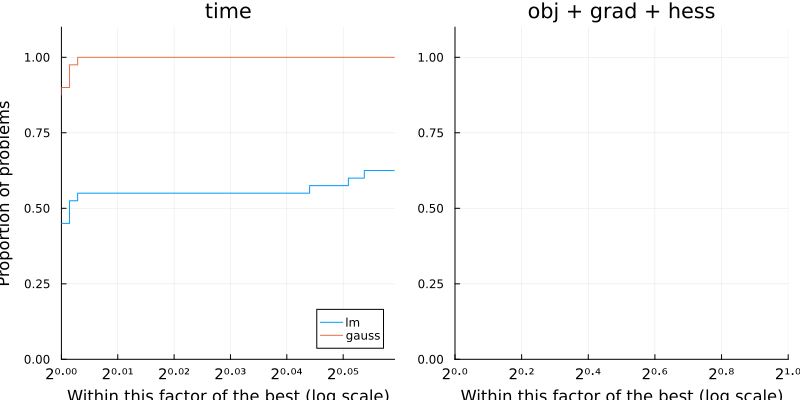

In [66]:
first_order(df) = df.status .== :first_order
unbounded(df) = df.status .== :unbounded
solved(df) = first_order(df) .| unbounded(df)
costnames = ["time", "obj + grad + hess"]
costs = [
  df -> .!solved(df) .* Inf .+ df.elapsed_time,
  df -> .!solved(df) .* Inf .+ df.neval_obj .+ df.neval_grad .+ df.neval_hess,
]

gr()

profile_solvers(stats, costs, costnames)

On observe que 40 problèmes on été utilisés pour le benchmark précédent. On voit que le problème mgh19 (ID69) diverge fortement avec la méthode de Gauss-Newton. Cependant, la méthode de Levenberg-Marquard est capable de résoudre ce problème dans difficulté, trouvant les conditions d'optimalité de premier ordre.